# Label data demo


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.features
import matplotlib.pyplot as plt

# from exactextract import exact_extract
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection

## MOSAIKS grid

The standard resolution of MOSAIKS is a global grid at 0.01° resolution. Each grid cell is approximately 1 km² at the equator. The grid is often represented as a point grid, where each point is the center of a grid cell. This means that standard MOSAIKS features come with a latitude and longitude coordinate, which is the center of the grid cell.

Here we show several ways to create a MOSAIKS grid for a given location.

> It is important to note that the grid is standardised such that the grid cells are centered at intervals of 0.005 degrees (e.g., 10.005, 10.015, 10.025,...).

There is no firm reason why this resolution was chosen, but it is a good compromise between resolution and computational efficiency. If a user is computing customized features for their application, they can choose a different resolution. However, it is important to note that the resolution of the grid will affect the computation time and the amount of data that needs to be stored.

### Create a grid for a given location

The following code creates a grid for a given location. The location can be given as a bounding box of the format `[minx, miny, maxx, maxy]`, a single polygon, or a dataframe with a geometry column. If a bounding box is given, the grid will be created for the bounding box. If a polygon is given, the grid will be created for the bounding box of the polygon, and then cropped to the polygon. If a dataframe is given, the grid will be created for the bounding box of each row, and then cropped to the geometry of that row, and it will be repeated for each row.


In [88]:
def create_grid(
    borders,
    resolution: float = 0.01,
    geometry_col: str = "geometry",
    id_col: str = "NAME",
    return_ids: bool = False,
) -> pd.DataFrame:
    """
    Create a grid of latitude and longitude coordinates for one or more geometries.
    It can accept a bounding box, a single polygon (or other Shapely geometry),
    or a GeoDataFrame with a geometry column.

    Parameters
    ----------
    borders : list or tuple or shapely.geometry.BaseGeometry or geopandas.GeoDataFrame
        - If list/tuple of length 4, interpreted as a bounding box: [minx, miny, maxx, maxy].
        - If a Shapely geometry (Polygon, MultiPolygon, etc.), creates a single-row GeoDataFrame.
        - If a GeoDataFrame, the function iterates over its rows.
    resolution : float, optional
        Grid resolution in degrees, default 0.01.
    geometry_col : str, optional
        Column name for the geometry in the resulting GeoDataFrame, by default "geometry".
    id_col : str, optional
        Column name in the GeoDataFrame to use as the ID column, or the name
        for the new column if bounding box / single polygon is provided. Default is "NAME".
    return_ids : bool, optional
        If True, generate and return the unique IDs for each grid cell. This will create a
        column 'unique_id' which follows the pattern 'lon_{lon}__lat_{lat}'. This option slows
        down the overall operation. Default is False.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns:
        - 'lat': latitude values (Y)
        - 'lon': longitude values (X)
        - `[id_col]`: the identifier for each geometry feature
        - 'unique_id': a string combining [id_col] + lon/lat for uniqueness (optional)
    """

    # 1. Convert input to a GeoDataFrame
    gdf = _to_geodataframe(borders, geometry_col, id_col)

    # 2. Ensure there's an ID column in the GeoDataFrame
    if id_col not in gdf.columns:
        # If user didn't provide an ID col for bounding box or single geometry,
        # assign a placeholder ID. For a multi-row GDF, user is expected to pass
        # an existing column name.
        gdf[id_col] = [f"feature_{i}" for i in range(len(gdf))]

    # 3. Rasterize each geometry and collect points
    result_list = []
    for _, row in gdf.iterrows():
        geom = row[geometry_col]
        this_id = row[id_col]

        if geom.is_empty:
            # Skip empty geometries
            continue

        minx, miny, maxx, maxy = geom.bounds

        # ---- Create arrays for lat and lon values (Note: lat reversed) ----
        # The 0.005 shift ensures that coordinates align on .005
        lats = np.arange(
            np.ceil(maxy / resolution) * resolution - 0.005, miny, -resolution
        )
        lons = np.arange(
            np.ceil(minx / resolution) * resolution + 0.005, maxx, resolution
        )

        if len(lats) == 0 or len(lons) == 0:
            # If bounding box is too small or resolution is large, might be empty
            continue

        # ---- Create a meshgrid ----
        lon_grid, lat_grid = np.meshgrid(lons, lats)

        # ---- Rasterize the geometry ----
        out_shape = (len(lats), len(lons))
        transform = rasterio.transform.from_bounds(
            minx, miny, maxx, maxy, out_shape[1], out_shape[0]
        )

        mask = rasterio.features.rasterize(
            [(geom, 1)],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype=np.uint8,
        )

        # ---- Extract the lat and lon values using the mask ----
        lat_values = lat_grid[mask == 1]
        lon_values = lon_grid[mask == 1]

        # ---- Create a DataFrame and append to the result list ----
        temp_df = pd.DataFrame({"lat": lat_values, "lon": lon_values})
        temp_df[id_col] = this_id
        result_list.append(temp_df)

    # 4. Concatenate the results
    if len(result_list) == 0:
        final_result = pd.DataFrame(columns=["lat", "lon", id_col, "unique_id"])
    else:
        final_result = pd.concat(result_list, ignore_index=True)
        if return_ids:
            # --- Create the unique_id column ---
            # e.g. 'lon_-10.005__lat_9.995'
            final_result["lon_rounded"] = final_result["lon"].round(3).astype(str)
            final_result["lat_rounded"] = final_result["lat"].round(3).astype(str)

            final_result["unique_id"] = (
                "lon_"
                + final_result["lon_rounded"]
                + "__lat_"
                + final_result["lat_rounded"]
            )

            final_result.drop(["lon_rounded", "lat_rounded"], axis=1, inplace=True)

    return final_result


def _to_geodataframe(borders, geometry_col: str, id_col: str) -> gpd.GeoDataFrame:
    """
    Internal helper that converts various input types into a standardized GeoDataFrame.

    Parameters
    ----------
    borders : list/tuple, shapely geometry, or GeoDataFrame
        Bounding box (list/tuple of length 4),
        single Shapely geometry (Polygon, MultiPolygon, etc.),
        or a GeoDataFrame.
    geometry_col : str
        The name of the geometry column to use or create.
    id_col : str
        The column in which to store or look for an ID (if relevant).

    Returns
    -------
    gpd.GeoDataFrame
        A GeoDataFrame with columns [id_col, geometry_col].
    """
    # Case 1: bounding box
    if isinstance(borders, (list, tuple)) and len(borders) == 4:
        minx, miny, maxx, maxy = borders
        geom = box(minx, miny, maxx, maxy)
        gdf = gpd.GeoDataFrame(
            {id_col: ["bbox_1"], geometry_col: [geom]}, crs="EPSG:4326"
        )

    # Case 2: single shapely geometry
    elif isinstance(borders, (Polygon, MultiPolygon, GeometryCollection)):
        gdf = gpd.GeoDataFrame(
            {id_col: ["geom_1"], geometry_col: [borders]}, crs="EPSG:4326"
        )

    # Case 3: GeoDataFrame
    elif isinstance(borders, gpd.GeoDataFrame):
        # If geometry_col does not exist, rename the current geometry column
        # so everything is consistent
        if geometry_col not in borders.columns:
            borders = borders.rename(columns={borders.geometry.name: geometry_col})

        gdf = borders.copy()
        gdf = gdf.set_geometry(geometry_col)

    else:
        raise ValueError(
            "Unsupported input for 'borders'. Must be one of:\n"
            "1) [minx, miny, maxx, maxy]\n"
            "2) A Shapely geometry (Polygon, MultiPolygon, etc.)\n"
            "3) A GeoDataFrame"
        )

    return gdf

### Create a grid for a bounding box

In the following example, we create a grid for an arbitrary bounding box.


In [89]:
# format [minx, miny, maxx, maxy]
bbox = [0.0, 0.0, 0.5, 0.5]
df_bbox = create_grid(
    bbox,
    resolution=0.01,
    geometry_col="geometry",
    id_col="NAME",
    # return_ids=True,
)
print(df_bbox.head())


     lat    lon    NAME
0  0.495  0.005  bbox_1
1  0.495  0.015  bbox_1
2  0.495  0.025  bbox_1
3  0.495  0.035  bbox_1
4  0.495  0.045  bbox_1


### Visualize the grid

Next we visualize the grid. To do this, we first create a GeoDataFrame with the grid points. We then buffer the points to create a polygon around each point. We use a `cap_style=3` to create square corners from the buffered points. Finally, we plot the grid points (green), the grid polygons (black), and the original bounding box (red).

**Note:** the following code produces a warning from the buffer operation. This is because the buffer operation is being conducted on geometry in a geographic CRS. This warning can be safely ignored in the context of MOSAIKS.


C:\Users\Cullen\AppData\Local\Temp\ipykernel_13808\1406033346.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_bbox.geometry = gdf_bbox.geometry.buffer(0.005, cap_style=3)


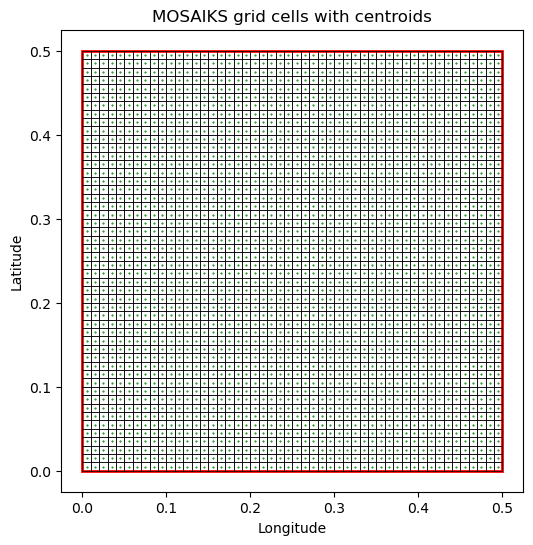

In [121]:
from matplotlib.patches import Rectangle

gdf_bbox = gpd.GeoDataFrame(
    df_bbox,
    geometry=gpd.points_from_xy(df_bbox.lon, df_bbox.lat),
    crs="EPSG:4326",
)
gdf_bbox.geometry = gdf_bbox.geometry.buffer(0.005, cap_style=3)

fig, ax = plt.subplots(figsize=(6, 6))

x_min, y_min, x_max, y_max = bbox
rect = Rectangle(
    (x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    fill=False,
    color="red",
    linewidth=2,
)
ax.add_patch(rect)

gdf_bbox.plot.scatter(x="lon", y="lat", s=0.25, c="green", ax=ax)
gdf_bbox.boundary.plot(ax=ax, color="black", linewidth=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("MOSAIKS grid cells with centroids")
plt.show()

### Create a grid for a polygon


In [222]:
dino_polygon = Polygon(
    [
        (0.000, 0.444),
        (0.136, 0.278),
        (0.227, 0.333),
        (0.318, 0.500),
        (0.364, 0.500),
        (0.409, 0.444),
        (0.455, 0.444),
        (0.500, 0.389),
        (0.500, 0.333),
        (0.364, 0.333),
        (0.500, 0.278),
        (0.455, 0.222),
        (0.364, 0.278),
        (0.364, 0.240),
        (0.390, 0.200),
        (0.390, 0.180),
        (0.364, 0.180),
        (0.318, 0.222),
        (0.273, 0.056),
        (0.318, 0.000),
        (0.227, 0.000),
        (0.182, 0.056),
        (0.136, 0.000),
        (0.091, 0.000),
        (0.045, 0.056),
        (0.091, 0.111),
        (0.136, 0.167),
        (0.045, 0.278),
    ]
)


df_grid = create_grid(dino_polygon, resolution=0.01)

print(df_grid.head())

     lat    lon    NAME
0  0.495  0.325  geom_1
1  0.495  0.335  geom_1
2  0.495  0.345  geom_1
3  0.495  0.355  geom_1
4  0.495  0.365  geom_1


C:\Users\Cullen\AppData\Local\Temp\ipykernel_13808\971513382.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_bbox.geometry = gdf_bbox.geometry.buffer(0.005, cap_style=3)


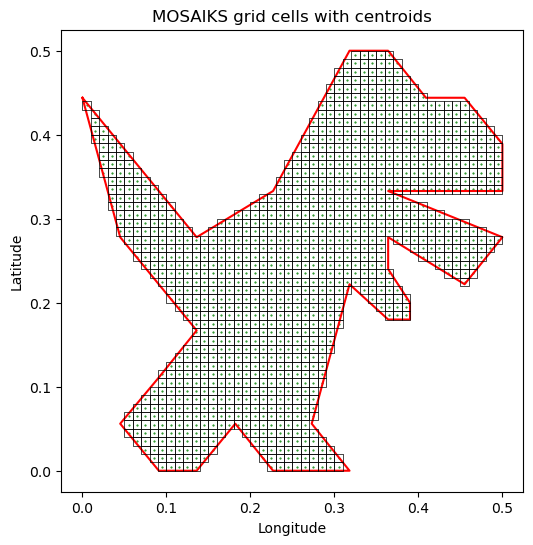

In [223]:
gdf_bbox = gpd.GeoDataFrame(
    df_grid,
    geometry=gpd.points_from_xy(df_grid.lon, df_grid.lat),
    crs="EPSG:4326",
)
gdf_bbox.geometry = gdf_bbox.geometry.buffer(0.005, cap_style=3)

fig, ax = plt.subplots(figsize=(6, 6))

x, y = dino_polygon.exterior.xy
ax.plot(x, y, color="red")

gdf_bbox.plot.scatter(x="lon", y="lat", s=0.25, c="green", ax=ax)

gdf_bbox.boundary.plot(ax=ax, color="black", linewidth=0.5)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("MOSAIKS grid cells with centroids")
plt.show()

### Create a grid for a GeoDataFrame

In the following example, we create a grid for a GeoDataFrame with a geometry column. The grid will be created for the bounding box of each row, and then cropped to the geometry of that row. First, we load an example of a GeoDataFrame with a geometry column, two countries in this case. We then create a grid for each country and visualize the grid for each country.


In [202]:
base_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen"

togo = f"{base_url}/TGO/ADM0/geoBoundaries-TGO-ADM0.geojson"
benin = f"{base_url}/BEN/ADM0/geoBoundaries-BEN-ADM0.geojson"

togo_gdf = gpd.read_file(togo)
benin_gdf = gpd.read_file(benin)

tgo_ben_gdf = pd.concat([togo_gdf, benin_gdf], ignore_index=True)
tgo_ben_gdf

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Togo,TGO,75638443B14388258762430,TGO,ADM0,"POLYGON ((-0.12366 11.137, -0.1309 11.13846, -..."
1,The Republic of Benin,BEN,84139743B99999625492710,BEN,ADM0,"POLYGON ((2.70495 6.46642, 2.70602 6.46941, 2...."


In [204]:
tgo_ben_grid = create_grid(
    tgo_ben_gdf,
    resolution=0.01,
    geometry_col="geometry",
    id_col="shapeISO",
    # return_ids=True,
)
tgo_ben_grid_gdf = gpd.GeoDataFrame(
    tgo_ben_grid,
    geometry=gpd.points_from_xy(tgo_ben_grid.lon, tgo_ben_grid.lat),
    crs="EPSG:4326",
)
tgo_ben_grid_gdf.geometry = tgo_ben_grid_gdf.geometry.buffer(0.005, cap_style=3)
# tgo_ben_grid
tgo_ben_grid_gdf

C:\Users\Cullen\AppData\Local\Temp\ipykernel_13808\1526364066.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tgo_ben_grid_gdf.geometry = tgo_ben_grid_gdf.geometry.buffer(0.005, cap_style=3)


,lat,lon,shapeISO,geometry
0,11.135,-0.125,TGO,"POLYGON ((-0.12 11.14, -0.12 11.13, -0.13 11.1..."
1,11.135,-0.115,TGO,"POLYGON ((-0.11 11.14, -0.11 11.13, -0.12 11.1..."
2,11.125,-0.135,TGO,"POLYGON ((-0.13 11.13, -0.13 11.12, -0.14 11.1..."
3,11.125,-0.125,TGO,"POLYGON ((-0.12 11.13, -0.12 11.12, -0.13 11.1..."
4,11.125,-0.115,TGO,"POLYGON ((-0.11 11.13, -0.11 11.12, -0.12 11.1..."
...,...,...,...,...
141545,6.235,1.685,BEN,"POLYGON ((1.69 6.24, 1.69 6.23, 1.68 6.23, 1.6..."
141546,6.235,1.695,BEN,"POLYGON ((1.7 6.24, 1.7 6.23, 1.69 6.23, 1.69 ..."
141547,6.235,1.705,BEN,"POLYGON ((1.71 6.24, 1.71 6.23, 1.7 6.23, 1.7 ..."
141548,6.225,1.655,BEN,"POLYGON ((1.66 6.23, 1.66 6.22, 1.65 6.22, 1.6..."


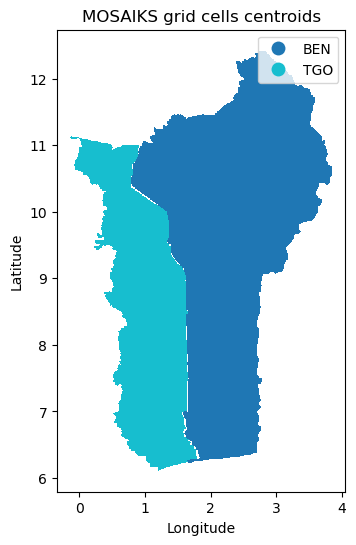

In [225]:
fig, ax = plt.subplots(figsize=(6, 6))

tgo_ben_grid_gdf.plot(column="shapeISO", ax=ax, legend=True)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("MOSAIKS grid cells centroids")
plt.show()

## Example 1: Vector Labels with Lat/Lon in a CSV

Scenario: You have a CSV containing locations (latitude, longitude) and some target variable (e.g., an economic indicator). In your notebook, you’ve loaded it into a DataFrame named XXXX.


In [ ]:
# Let's assume 'XXXX' is a pandas DataFrame with columns: 'latitude', 'longitude', 'label_value'.

# Convert pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    XXXX,
    geometry=gpd.points_from_xy(XXXX["longitude"], XXXX["latitude"]),
    crs="EPSG:4326",  # WGS 84
)

# Inspect your data
print(gdf.head())

# Optionally reproject to a projected coordinate system (example: UTM)
gdf_utm = gdf.to_crs("EPSG:3857")  # just an example


In [ ]:
!wget https://download.geofabrik.de/africa/togo-latest-free.shp.zip